# Main script to clean UW final satellite pm2.5 data

## Model 1: zip_ssn

Modules: N/A <br>
Author: Cornelia Ilin <br>
Email: cilin@wisc.edu <br>
Date created: Oct 20, 2020 <br>

**Citations (data sources)**

``PM 25 at the monthly level:``
1. https://sites.wustl.edu/acag/datasets/historical-pm2-5-across-north-america/


``Shapefiles for California ZIP codes (2010 census):``

3. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas
    
**Citations (persons)**
1. N/A

**Preferred environment**
1. Code written in Jupyter Notebooks

#### Step 1: Import packages

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 11.3 MB/s 
     |████████████████████████████████| 16.7 MB 57.1 MB/s 
     |████████████████████████████████| 6.3 MB 48.1 MB/s 


In [2]:
!pip install osmnx
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 3.9 MB/s 
     |████████████████████████████████| 1.0 MB 56.1 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 11.2 MB 68.8 MB/s 
     |████████████████████████████████| 959 kB 60.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install xarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# standard
import pandas as pd
import numpy as np
import os
import h5py
import time
import seaborn as sns

# geography
import geopandas as gpd
import osmnx as ox
import shapely

# netcdf
import xarray as xr



#### Step 2: Define working directories

In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')
data_path = '/content/MyDrive/MyDrive/W210_Capstone/code'

os.chdir(data_path)
os.listdir(data_path)

Mounted at /content/MyDrive


['output',
 'tl_2010_06_zcta510',
 'original_uw_cleaning_final_zip_monthly.ipynb',
 'netcdf',
 'PM25_monthly_netcdf',
 'uw_cleaning_final_zip_monthly.ipynb',
 'uw_cleaning_final_zip_monthly_AP_9-17-22.ipynb']

In [3]:
!pwd

/content/MyDrive/.shortcut-targets-by-id/11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E/W210_Capstone/code


In [4]:
in_dir_zip_shapes = 'tl_2010_06_zcta510/shapefiles/'
in_dir = "pm25_monthly/"
out_dir = 'output/'

#### Step 3: Define functions

``read data``

In [ ]:
def read_census_geom():
    """ Read Census (lat, lon) coordinates for California zip-codes
    parameters:
    -----------
    None
    
    return:
    -------
    Df with osmnx_geom
    """
    ### Step 1 ### 
    ##############
    # Read the shapefiles for California's ZIP codes
    for file in os.listdir(in_dir_zip_shapes):
        if file.endswith('.shp'):
            gdf = gpd.read_file(in_dir_zip_shapes + file)

    # keep only cols of interest 
    # ('ZCTA5CE10' = 2010 Census ZIP codes,	'GEOID10' = 2010 Census Tract codes)
    gdf = gdf[['ZCTA5CE10',	'GEOID10', 'geometry']]
    
    
    ### Step 2 ###
    ###############
    # For each zip cpde extract polygon with (lat, lon) info

    zip_poly = pd.DataFrame()

    for idx, multipoly in enumerate(gdf.geometry):
        if isinstance(multipoly, shapely.geometry.polygon.Polygon):
            temp_df = pd.DataFrame({'latitude': multipoly.exterior.coords.xy[1], 
                                    'longitude': multipoly.exterior.coords.xy[0],
                                    'ZIP10': gdf.loc[idx, 'ZCTA5CE10'],
                                    'GEOID10': gdf.loc[idx, 'GEOID10']})
            zip_poly = pd.concat([zip_poly, temp_df], axis=0)

        if isinstance(multipoly, shapely.geometry.multipolygon.MultiPolygon):
            for poly in multipoly:
                temp_df = pd.DataFrame({'latitude': poly.exterior.coords.xy[1], 
                                        'longitude': poly.exterior.coords.xy[0],
                                        'ZIP10': gdf.loc[idx, 'ZCTA5CE10'],
                                        'GEOID10': gdf.loc[idx, 'GEOID10']})
                zip_poly = pd.concat([zip_poly, temp_df], axis=0)   
    

    # round (lat, lon) to 2 decimal points and add 0.005 to match the UW (lat, lon) values
    zip_poly['latitude'] = zip_poly.latitude.round(2) + 0.005
    zip_poly['longitude'] = zip_poly.longitude.round(2) + 0.005
    zip_poly.sort_values(by=['ZIP10', 'latitude', 'longitude'], inplace=True)
    zip_poly.drop_duplicates(subset=['ZIP10', 'latitude', 'longitude'], inplace=True)

    
    return zip_poly

for the function below try to read the data using the ftplib in python (secure file transfer)

In [ ]:
def read_uw_pm25(zip_poly):
    """Read UW pm25 data
    parameters:
    -----------
    osmnx_geom: df, contains osmnx_geom and county name/code
    
    return:
    df with pm25 values by year and county in California
    """
    df = pd.DataFrame()
    
    for idx, file in enumerate(os.listdir(in_dir)):
        if file.endswith('.h5'):
            print(file[:4])
            # read data
            f = h5py.File(os.path.join(in_dir, file), 'r')
            # read latitude
            row_index = f['latitude']
            row_index = pd.DataFrame(row_index, columns=['latitude'])
            # read longitude
            col_index = f['longitude']
            col_index = pd.DataFrame(col_index, columns = ['longitude'])
            # read pm25 (divide by 100 as indicated here: https://zenodo.org/record/2616769#.X4999NBKg4c)
            pm25 = f['CorrectedPM2.5']
            pm25 = pd.DataFrame(pm25)/100

            # add col and row index to pm25_df
            pm25.set_index(row_index.latitude.values, inplace=True)
            pm25.columns = col_index.longitude.values
            pm25.reset_index(drop=False, inplace=True)
            pm25.rename(columns={'index':'latitude'}, inplace=True)

            # melt pm25_df
            pm25 = pd.melt(pm25, id_vars='latitude', var_name='longitude', value_vars=col_index.longitude.values, value_name='pm25')
            pm25.sort_values(by=['latitude', 'longitude'], inplace=True)

            # set lat and lon to 3 decimals
            pm25['latitude'] = pm25.latitude.round(3)
            pm25['longitude'] = pm25.longitude.astype(float).round(3)

            # add year column
            pm25['year'] = file[:4]

            # merge with zip_poly
            pm25 = zip_poly.merge(pm25, on=['latitude', 'longitude'], how='inner')

            # group by zip code and census tract (get mean for each zip code)
            pm25 = pm25.groupby(['year', 'ZIP10', 'GEOID10'], as_index=False).agg({'pm25': np.mean})

            # add year and zip column
            pm25['year_zip'] = pm25.year.astype(str) + '.0_' + pm25.ZIP10.astype(str) + '.0'

            # append to df
            df = pd.concat([df, pm25], axis=0)
    
    # sort and reset index
    df.sort_values(by=['year'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

#### Step 4: Read data

In [ ]:
zip_poly = read_census_geom()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


In [ ]:
df = read_uw_pm25(zip_poly)

1999
2000
2001
2002
2003
2004
2006
2005
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [ ]:
df.sort_values(by=['ZIP10', 'GEOID10', 'year'], inplace=True)

In [ ]:
df.to_csv(out_dir + 'UW_pm25_zip_monthly.csv')

In [ ]:
df.head(20)

,year,ZIP10,GEOID10,pm25,year_zip
0,1999,89010,0689010,4.793571,1999.0_89010.0
2932,2000,89010,0689010,4.797143,2000.0_89010.0
4829,2001,89010,0689010,4.833571,2001.0_89010.0
6443,2002,89010,0689010,4.914286,2002.0_89010.0
8341,2003,89010,0689010,4.793571,2003.0_89010.0
10097,2004,89010,0689010,4.885714,2004.0_89010.0
12291,2005,89010,0689010,4.499286,2005.0_89010.0
12869,2006,89010,0689010,4.279286,2006.0_89010.0
15224,2007,89010,0689010,4.537143,2007.0_89010.0
17121,2008,89010,0689010,5.107857,2008.0_89010.0


---
# Anand's Work

In [ ]:
display(zip_poly)

,latitude,longitude,ZIP10,GEOID10
235,37.465,-117.925,89010,0689010
234,37.465,-117.915,89010,0689010
227,37.465,-117.905,89010,0689010
216,37.465,-117.895,89010,0689010
202,37.465,-117.885,89010,0689010
...,...,...,...,...
766,41.995,-120.275,97635,0697635
767,41.995,-120.265,97635,0697635
768,41.995,-120.255,97635,0697635
770,41.995,-120.245,97635,0697635


In [ ]:
# load in and check out the csv we made before for yearly pm25 readings
df = pd.read_csv(out_dir + 'UW_pm25_zip_monthly.csv', index_col=0)
df.head()

,year,ZIP10,GEOID10,pm25,year_zip
0,1999,89010,689010,4.793571,1999.0_89010.0
2932,2000,89010,689010,4.797143,2000.0_89010.0
4829,2001,89010,689010,4.833571,2001.0_89010.0
6443,2002,89010,689010,4.914286,2002.0_89010.0
8341,2003,89010,689010,4.793571,2003.0_89010.0


<AxesSubplot:>

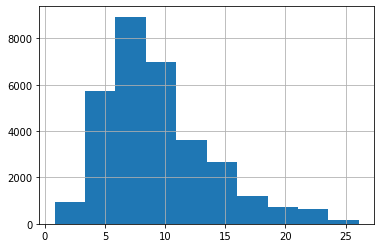

In [ ]:
import matplotlib as plt
df.pm25.hist()

In [ ]:
df.ZIP10.nunique()

1756

In [ ]:
# verify the number of rows after this are the same, meaning that we actually have yearly data, not monthly
temp = df.groupby(['ZIP10', 'year'])['pm25'].count()
print(temp.shape)
print(df.shape)

(31608,)
(31608, 5)


In [ ]:
df_temp = pd.read_hdf('pm25_monthly/1999.h5')

ValueError: ignored

## Break down what is happening inside the function

In [ ]:
f = h5py.File(os.path.join(in_dir, '1999.h5'), 'r')

In [ ]:
f

<HDF5 file "1999.h5" (mode r)>

In [ ]:
print(f['latitude'])
row_index = f['latitude']
row_index = pd.DataFrame(row_index, columns=['latitude'])
display(row_index)

<HDF5 dataset "latitude": shape (5600,), type "<f4">


,latitude
0,12.005000
1,12.015000
2,12.025001
3,12.035000
4,12.045000
...,...
5595,67.954994
5596,67.964996
5597,67.974998
5598,67.985001


In [ ]:
print(f['longitude'])
col_index = f['longitude']
col_index = pd.DataFrame(col_index, columns = ['longitude'])
display(col_index)

<HDF5 dataset "longitude": shape (9600,), type "<f4">


,longitude
0,-137.994995
1,-137.985001
2,-137.974991
3,-137.964996
4,-137.955002
...,...
9595,-42.044998
9596,-42.034996
9597,-42.024994
9598,-42.014999


In [ ]:
print(f['CorrectedPM2.5'])
pm25 = f['CorrectedPM2.5']
pm25 = pd.DataFrame(pm25)/100
display(pm25)

<HDF5 dataset "CorrectedPM2.5": shape (5600, 9600), type "<i2">


,0,1,2,3,4,5,6,7,8,9,...,9590,9591,9592,9593,9594,9595,9596,9597,9598,9599
0,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.40,18.38,18.36,18.35,18.33,18.31,18.30
1,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.40,18.39,18.37,18.34,18.33,18.31,18.30
2,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.40,18.39,18.37,18.34,18.33,18.31,18.30
3,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.40,18.37,18.37,18.34,18.34,18.31,18.31
4,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.40,18.37,18.37,18.34,18.34,18.31,18.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,5.37,5.43,5.53,5.52,5.43,5.37,5.34,5.32,5.41,5.38,...,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66
5596,5.46,5.44,5.44,5.46,5.45,5.35,5.34,5.34,5.28,5.25,...,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66
5597,5.13,5.19,5.28,5.31,5.27,5.24,5.17,5.25,5.13,5.09,...,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66
5598,5.25,5.21,4.50,4.40,4.41,4.35,4.42,4.42,4.51,5.11,...,0.66,0.66,0.67,0.66,0.66,0.66,0.66,0.66,0.66,0.66


In [ ]:
# add col and row index to pm25_df
pm25.set_index(row_index.latitude.values, inplace=True)
display(pm25.head())

pm25.columns = col_index.longitude.values
display(pm25.head())

pm25.reset_index(drop=False, inplace=True)
pm25.rename(columns={'index':'latitude'}, inplace=True)
display(pm25.head())

,0,1,2,3,4,5,6,7,8,9,...,9590,9591,9592,9593,9594,9595,9596,9597,9598,9599
12.005000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.38,18.36,18.35,18.33,18.31,18.30
12.015000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.39,18.37,18.34,18.33,18.31,18.30
12.025001,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.39,18.37,18.34,18.33,18.31,18.30
12.035000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.4,18.37,18.37,18.34,18.34,18.31,18.31
12.045000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.4,18.37,18.37,18.34,18.34,18.31,18.31


,-137.994995,-137.985001,-137.974991,-137.964996,-137.955002,-137.944992,-137.934998,-137.924988,-137.914993,-137.904999,...,-42.094994,-42.084999,-42.074997,-42.064995,-42.055000,-42.044998,-42.034996,-42.024994,-42.014999,-42.004997
12.005000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.38,18.36,18.35,18.33,18.31,18.30
12.015000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.39,18.37,18.34,18.33,18.31,18.30
12.025001,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.39,18.37,18.34,18.33,18.31,18.30
12.035000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.4,18.37,18.37,18.34,18.34,18.31,18.31
12.045000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.4,18.37,18.37,18.34,18.34,18.31,18.31


,latitude,-137.9949951171875,-137.98500061035156,-137.97499084472656,-137.96499633789062,-137.9550018310547,-137.9449920654297,-137.93499755859375,-137.92498779296875,-137.9149932861328,...,-42.094993591308594,-42.084999084472656,-42.07499694824219,-42.06499481201172,-42.05500030517578,-42.04499816894531,-42.034996032714844,-42.024993896484375,-42.01499938964844,-42.00499725341797
0,12.005000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.38,18.36,18.35,18.33,18.31,18.30
1,12.015000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.39,18.37,18.34,18.33,18.31,18.30
2,12.025001,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.4,18.39,18.37,18.34,18.33,18.31,18.30
3,12.035000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.4,18.37,18.37,18.34,18.34,18.31,18.31
4,12.045000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.4,18.37,18.37,18.34,18.34,18.31,18.31


In [ ]:
pm25

,latitude,-137.9949951171875,-137.98500061035156,-137.97499084472656,-137.96499633789062,-137.9550018310547,-137.9449920654297,-137.93499755859375,-137.92498779296875,-137.9149932861328,...,-42.094993591308594,-42.084999084472656,-42.07499694824219,-42.06499481201172,-42.05500030517578,-42.04499816894531,-42.034996032714844,-42.024993896484375,-42.01499938964844,-42.00499725341797
0,12.005000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.40,18.38,18.36,18.35,18.33,18.31,18.30
1,12.015000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.40,18.39,18.37,18.34,18.33,18.31,18.30
2,12.025001,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.45,18.43,18.42,18.40,18.39,18.37,18.34,18.33,18.31,18.30
3,12.035000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.40,18.37,18.37,18.34,18.34,18.31,18.31
4,12.045000,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,...,18.46,18.43,18.40,18.40,18.37,18.37,18.34,18.34,18.31,18.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,67.954994,5.37,5.43,5.53,5.52,5.43,5.37,5.34,5.32,5.41,...,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66
5596,67.964996,5.46,5.44,5.44,5.46,5.45,5.35,5.34,5.34,5.28,...,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66
5597,67.974998,5.13,5.19,5.28,5.31,5.27,5.24,5.17,5.25,5.13,...,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66
5598,67.985001,5.25,5.21,4.50,4.40,4.41,4.35,4.42,4.42,4.51,...,0.66,0.66,0.67,0.66,0.66,0.66,0.66,0.66,0.66,0.66


In [ ]:
# melt pm25_df
pm25 = pd.melt(pm25, id_vars='latitude', var_name='longitude', value_vars=col_index.longitude.values, value_name='pm25')
display(pm25)

,latitude,longitude,pm25
0,12.005000,-137.994995,1.96
1,12.015000,-137.994995,1.96
2,12.025001,-137.994995,1.96
3,12.035000,-137.994995,1.96
4,12.045000,-137.994995,1.96
...,...,...,...
53759995,67.954994,-42.004997,0.66
53759996,67.964996,-42.004997,0.66
53759997,67.974998,-42.004997,0.66
53759998,67.985001,-42.004997,0.66


In [ ]:
pm25.sort_values(by=['latitude', 'longitude'], inplace=True)


In [ ]:
# set lat and lon to 3 decimals
pm25['latitude'] = pm25.latitude.round(3)
pm25['longitude'] = pm25.longitude.astype(float).round(3)

In [ ]:
display(pm25.head())

# add year column
pm25['year'] = '1999-mm'

display(pm25)

,latitude,longitude,pm25,year
0,12.005,-137.995,1.96,1999-mm
5600,12.005,-137.985,1.96,1999-mm
11200,12.005,-137.975,1.96,1999-mm
16800,12.005,-137.965,1.96,1999-mm
22400,12.005,-137.955,1.96,1999-mm


,latitude,longitude,pm25,year
0,12.005,-137.995,1.96,1999-mm
5600,12.005,-137.985,1.96,1999-mm
11200,12.005,-137.975,1.96,1999-mm
16800,12.005,-137.965,1.96,1999-mm
22400,12.005,-137.955,1.96,1999-mm
...,...,...,...,...
53737599,67.995,-42.045,0.66,1999-mm
53743199,67.995,-42.035,0.66,1999-mm
53748799,67.995,-42.025,0.66,1999-mm
53754399,67.995,-42.015,0.66,1999-mm


In [ ]:
# merge with zip_poly
pm25 = zip_poly.merge(pm25, on=['latitude', 'longitude'], how='inner')

display(pm25)

,latitude,longitude,ZIP10,GEOID10,pm25,year
0,37.465,-117.915,89010,0689010,4.82,1999-mm
1,37.465,-117.915,93513,0693513,4.82,1999-mm
2,37.465,-117.905,89010,0689010,4.84,1999-mm
3,37.465,-117.905,93513,0693513,4.84,1999-mm
4,37.465,-117.885,89010,0689010,4.87,1999-mm
...,...,...,...,...,...,...
54978,41.985,-120.325,97635,0697635,4.98,1999-mm
54979,41.985,-120.315,97635,0697635,5.15,1999-mm
54980,41.985,-120.245,97635,0697635,3.89,1999-mm
54981,41.985,-120.235,97635,0697635,3.59,1999-mm


In [ ]:
# group by zip code and census tract (get mean for each zip code)
pm25 = pm25.groupby(['year', 'ZIP10', 'GEOID10'], as_index=False).agg({'pm25': np.mean})
display(pm25)

,year,ZIP10,GEOID10,pm25
0,1999-mm,89010,0689010,4.793571
1,1999-mm,89019,0689019,5.636081
2,1999-mm,89060,0689060,5.557000
3,1999-mm,89061,0689061,6.356667
4,1999-mm,89439,0689439,5.287778
...,...,...,...,...
1751,1999-mm,96148,0696148,3.902857
1752,1999-mm,96150,0696150,3.845111
1753,1999-mm,96155,0696155,3.540400
1754,1999-mm,96161,0696161,4.888684


In [ ]:
# print(file[:4])
# # read data
# f = h5py.File(os.path.join(in_dir, file), 'r')
# read latitude
row_index = f['latitude']
row_index = pd.DataFrame(row_index, columns=['latitude'])
# read longitude
col_index = f['longitude']
col_index = pd.DataFrame(col_index, columns = ['longitude'])
# read pm25 (divide by 100 as indicated here: https://zenodo.org/record/2616769#.X4999NBKg4c)
pm25 = f['CorrectedPM2.5']
pm25 = pd.DataFrame(pm25)/100

# add col and row index to pm25_df
pm25.set_index(row_index.latitude.values, inplace=True)
pm25.columns = col_index.longitude.values
pm25.reset_index(drop=False, inplace=True)
pm25.rename(columns={'index':'latitude'}, inplace=True)

# melt pm25_df
pm25 = pd.melt(pm25, id_vars='latitude', var_name='longitude', value_vars=col_index.longitude.values, value_name='pm25')
pm25.sort_values(by=['latitude', 'longitude'], inplace=True)

# set lat and lon to 3 decimals
pm25['latitude'] = pm25.latitude.round(3)
pm25['longitude'] = pm25.longitude.astype(float).round(3)

# add year column
pm25['year'] = file[:4]

# merge with zip_poly
pm25 = zip_poly.merge(pm25, on=['latitude', 'longitude'], how='inner')

# group by zip code and census tract (get mean for each zip code)
pm25 = pm25.groupby(['year', 'ZIP10', 'GEOID10'], as_index=False).agg({'pm25': np.mean})

# add year and zip column
pm25['year_zip'] = pm25.year.astype(str) + '.0_' + pm25.ZIP10.astype(str) + '.0'

# append to df
df = pd.concat([df, pm25], axis=0)

## Working with netcdf

```
import xarray as xr

ds = xr.open_dataset('/path/to/netcdf')
df = ds.to_dataframe()
```

In [ ]:
import xarray as xr

ds = xr.open_dataset('netcdf/V4NA03_PM25_NA_201701_201701-RH35.nc')
df_month = ds.to_dataframe()

In [ ]:
df_month

PM25
LON      LAT         
-137.995 67.995   0.0
         67.985   0.0
         67.975   0.1
         67.965   0.2
         67.955   0.4
...               ...
-45.005  22.545   NaN
         22.535   NaN
         22.525   NaN
         22.515   NaN
         22.505   NaN

[42315000 rows x 1 columns]

In [ ]:
df_month.describe()

,PM25
count,2.278614e+07
mean,2.840827e+00
std,2.405234e+00
min,0.000000e+00
25%,1.000000e+00
50%,2.400000e+00
75%,4.200000e+00
max,2.290000e+01


<AxesSubplot:>

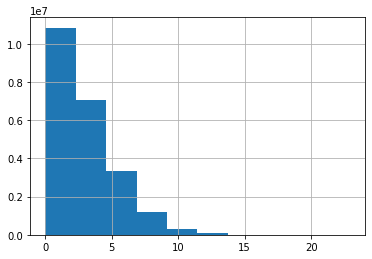

In [ ]:
df_month.PM25.hist()

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (LON: 9300, LAT: 4550)
Coordinates:
  * LON      (LON) float64 -138.0 -138.0 -138.0 -138.0 ... -45.02 -45.02 -45.01
  * LAT      (LAT) float64 68.0 67.98 67.97 67.97 ... 22.54 22.52 22.52 22.5
Data variables:
    PM25     (LAT, LON) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [ ]:
ds['LAT']

<xarray.DataArray 'LAT' (LAT: 4550)>
array([67.995, 67.985, 67.975, ..., 22.525, 22.515, 22.505])
Coordinates:
  * LAT      (LAT) float64 68.0 67.98 67.97 67.97 ... 22.54 22.52 22.52 22.5
Attributes:
    standard_name:  latitude
    long_name:      latitude centre
    units:          degrees_north

In [ ]:
ds['LAT'].shape

(4550,)

In [ ]:
ds['LON']

<xarray.DataArray 'LON' (LON: 9300)>
array([-137.995  , -137.985  , -137.97501, ...,  -45.025  ,  -45.015  ,
        -45.005  ])
Coordinates:
  * LON      (LON) float64 -138.0 -138.0 -138.0 -138.0 ... -45.02 -45.02 -45.01
Attributes:
    standard_name:  longitude
    long_name:      longitude centre
    units:          degrees_east

In [ ]:
ds['LON'].shape

(9300,)

In [ ]:
ds['PM25']

<xarray.DataArray 'PM25' (LAT: 4550, LON: 9300)>
array([[0. , 0. , 0. , ..., 1.7, 1.7, 1.7],
       [0. , 0. , 0. , ..., 1.6, 1.7, 1.7],
       [0.1, 0.1, 0. , ..., 1.6, 1.6, 1.6],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * LON      (LON) float64 -138.0 -138.0 -138.0 -138.0 ... -45.02 -45.02 -45.01
  * LAT      (LAT) float64 68.0 67.98 67.97 67.97 ... 22.54 22.52 22.52 22.5
Attributes:
    standard_name:  PM25
    units:          ug/m3

In [ ]:
ds['PM25'].shape

(4550, 9300)

## Try to form dataframe with netcdf data

In [ ]:
print(ds['LAT'])
row_index = ds['LAT']
row_index = pd.DataFrame(row_index, columns=['latitude'])
display(row_index)

<xarray.DataArray 'LAT' (LAT: 4550)>
array([67.995, 67.985, 67.975, ..., 22.525, 22.515, 22.505])
Coordinates:
  * LAT      (LAT) float64 68.0 67.98 67.97 67.97 ... 22.54 22.52 22.52 22.5
Attributes:
    standard_name:  latitude
    long_name:      latitude centre
    units:          degrees_north


,latitude
0,67.995
1,67.985
2,67.975
3,67.965
4,67.955
...,...
4545,22.545
4546,22.535
4547,22.525
4548,22.515


In [ ]:
print(ds['LON'])
col_index = ds['LON']
col_index = pd.DataFrame(col_index, columns = ['longitude'])
display(col_index)

<xarray.DataArray 'LON' (LON: 9300)>
array([-137.995  , -137.985  , -137.97501, ...,  -45.025  ,  -45.015  ,
        -45.005  ])
Coordinates:
  * LON      (LON) float64 -138.0 -138.0 -138.0 -138.0 ... -45.02 -45.02 -45.01
Attributes:
    standard_name:  longitude
    long_name:      longitude centre
    units:          degrees_east


,longitude
0,-137.99500
1,-137.98500
2,-137.97501
3,-137.96500
4,-137.95500
...,...
9295,-45.04500
9296,-45.03500
9297,-45.02500
9298,-45.01500


In [ ]:
print(ds['PM25'])
pm25 = ds['PM25']
pm25 = pd.DataFrame(pm25)
display(pm25)

<xarray.DataArray 'PM25' (LAT: 4550, LON: 9300)>
array([[0. , 0. , 0. , ..., 1.7, 1.7, 1.7],
       [0. , 0. , 0. , ..., 1.6, 1.7, 1.7],
       [0.1, 0.1, 0. , ..., 1.6, 1.6, 1.6],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * LON      (LON) float64 -138.0 -138.0 -138.0 -138.0 ... -45.02 -45.02 -45.01
  * LAT      (LAT) float64 68.0 67.98 67.97 67.97 ... 22.54 22.52 22.52 22.5
Attributes:
    standard_name:  PM25
    units:          ug/m3


KeyboardInterrupt: ignored

In [ ]:
print(ds['PM25'])
pm25 = ds['PM25']

<xarray.DataArray 'PM25' (LAT: 4550, LON: 9300)>
array([[0. , 0. , 0. , ..., 1.7, 1.7, 1.7],
       [0. , 0. , 0. , ..., 1.6, 1.7, 1.7],
       [0.1, 0.1, 0. , ..., 1.6, 1.6, 1.6],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * LON      (LON) float64 -138.0 -138.0 -138.0 -138.0 ... -45.02 -45.02 -45.01
  * LAT      (LAT) float64 68.0 67.98 67.97 67.97 ... 22.54 22.52 22.52 22.5
Attributes:
    standard_name:  PM25
    units:          ug/m3


In [ ]:
pm25 = pm25.to_pandas()
display(pm25)

LON,-137.99500,-137.98500,-137.97501,-137.96500,-137.95500,-137.94501,-137.93500,-137.92500,-137.91499,-137.90500,...,-45.09500,-45.08500,-45.07500,-45.06500,-45.05500,-45.04500,-45.03500,-45.02500,-45.01500,-45.00500
LAT,,,,,,,,,,,,,,,,,,,,,
67.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.7,1.6,1.7,1.7,1.7
67.985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.7,1.7
67.975,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
67.965,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
67.955,0.4,0.5,0.5,0.4,0.3,0.2,0.3,0.3,0.3,0.2,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22.545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22.535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22.525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# add col and row index to pm25_df
pm25.set_index(row_index.latitude.values, inplace=True)
display(pm25.head())

pm25.columns = col_index.longitude.values
display(pm25.head())

pm25.reset_index(drop=False, inplace=True)
pm25.rename(columns={'index':'latitude'}, inplace=True)
display(pm25.head())

LON,-137.99500,-137.98500,-137.97501,-137.96500,-137.95500,-137.94501,-137.93500,-137.92500,-137.91499,-137.90500,...,-45.09500,-45.08500,-45.07500,-45.06500,-45.05500,-45.04500,-45.03500,-45.02500,-45.01500,-45.00500
67.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.7,1.6,1.7,1.7,1.7
67.985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.7,1.7
67.975,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
67.965,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
67.955,0.4,0.5,0.5,0.4,0.3,0.2,0.3,0.3,0.3,0.2,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6


,-137.99500,-137.98500,-137.97501,-137.96500,-137.95500,-137.94501,-137.93500,-137.92500,-137.91499,-137.90500,...,-45.09500,-45.08500,-45.07500,-45.06500,-45.05500,-45.04500,-45.03500,-45.02500,-45.01500,-45.00500
67.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.7,1.6,1.7,1.7,1.7
67.985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.7,1.7
67.975,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
67.965,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
67.955,0.4,0.5,0.5,0.4,0.3,0.2,0.3,0.3,0.3,0.2,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6


,latitude,-137.995,-137.985,-137.97501,-137.965,-137.955,-137.94501,-137.935,-137.925,-137.91499,...,-45.095,-45.085,-45.075,-45.065,-45.055,-45.045,-45.035,-45.025,-45.015,-45.005
0,67.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.7,1.6,1.7,1.7,1.7
1,67.985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.7,1.7
2,67.975,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
3,67.965,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
4,67.955,0.4,0.5,0.5,0.4,0.3,0.2,0.3,0.3,0.3,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6


In [ ]:
pm25

,latitude,-137.995,-137.985,-137.97501,-137.965,-137.955,-137.94501,-137.935,-137.925,-137.91499,...,-45.095,-45.085,-45.075,-45.065,-45.055,-45.045,-45.035,-45.025,-45.015,-45.005
0,67.995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.7,1.6,1.7,1.7,1.7
1,67.985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.7,1.7
2,67.975,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
3,67.965,0.2,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.0,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
4,67.955,0.4,0.5,0.5,0.4,0.3,0.2,0.3,0.3,0.3,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4545,22.545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4546,22.535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547,22.525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4548,22.515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# melt pm25_df
pm25 = pd.melt(pm25, id_vars='latitude', var_name='longitude', value_vars=col_index.longitude.values, value_name='pm25')
display(pm25)

,latitude,longitude,pm25
0,67.995,-137.995,0.0
1,67.985,-137.995,0.0
2,67.975,-137.995,0.1
3,67.965,-137.995,0.2
4,67.955,-137.995,0.4
...,...,...,...
42314995,22.545,-45.005,NaN
42314996,22.535,-45.005,NaN
42314997,22.525,-45.005,NaN
42314998,22.515,-45.005,NaN


In [ ]:
pm25.sort_values(by=['latitude', 'longitude'], inplace=True)


In [ ]:
# set lat and lon to 3 decimals
pm25['latitude'] = pm25.latitude.round(3)
pm25['longitude'] = pm25.longitude.astype(float).round(3)

In [ ]:
fname_netcdf = 'netcdf/V4NA03_PM25_NA_201701_201701-RH35.nc'
year_month_str = fname_netcdf[22:26] + '-' + fname_netcdf[26:28]
print(year_month_str) 

2017-01


In [ ]:
display(pm25.head())

# add year column
pm25['year_month'] = year_month_str

display(pm25)

,latitude,longitude,pm25
4549,22.505,-137.995,NaN
9099,22.505,-137.985,NaN
13649,22.505,-137.975,NaN
18199,22.505,-137.965,NaN
22749,22.505,-137.955,NaN


,latitude,longitude,pm25,year_month
4549,22.505,-137.995,NaN,2017-01
9099,22.505,-137.985,NaN,2017-01
13649,22.505,-137.975,NaN,2017-01
18199,22.505,-137.965,NaN,2017-01
22749,22.505,-137.955,NaN,2017-01
...,...,...,...,...
42292250,67.995,-45.045,1.7,2017-01
42296800,67.995,-45.035,1.6,2017-01
42301350,67.995,-45.025,1.7,2017-01
42305900,67.995,-45.015,1.7,2017-01


In [ ]:
# merge with zip_poly
pm25 = zip_poly.merge(pm25, on=['latitude', 'longitude'], how='inner')

display(pm25)

,latitude,longitude,ZIP10,GEOID10,pm25,year_month
0,37.465,-117.915,89010,0689010,2.0,2017-01
1,37.465,-117.915,93513,0693513,2.0,2017-01
2,37.465,-117.905,89010,0689010,2.0,2017-01
3,37.465,-117.905,93513,0693513,2.0,2017-01
4,37.465,-117.885,89010,0689010,2.0,2017-01
...,...,...,...,...,...,...
54978,41.985,-120.325,97635,0697635,2.6,2017-01
54979,41.985,-120.315,97635,0697635,2.6,2017-01
54980,41.985,-120.245,97635,0697635,0.0,2017-01
54981,41.985,-120.235,97635,0697635,0.0,2017-01


In [ ]:
# group by zip code and census tract (get mean for each zip code)
pm25 = pm25.groupby(['year_month', 'ZIP10', 'GEOID10'], as_index=False).agg({'pm25': np.mean})
display(pm25)

,year_month,ZIP10,GEOID10,pm25
0,2017-01,89010,0689010,1.842857
1,2017-01,89019,0689019,3.401351
2,2017-01,89060,0689060,3.400000
3,2017-01,89061,0689061,3.700000
4,2017-01,89439,0689439,1.288889
...,...,...,...,...
1751,2017-01,96148,0696148,0.057143
1752,2017-01,96150,0696150,0.457778
1753,2017-01,96155,0696155,0.032000
1754,2017-01,96161,0696161,0.629825


In [ ]:
pm25.isna().sum()

year_month    0
ZIP10         0
GEOID10       0
pm25          3
dtype: int64

In [ ]:
pm25.describe()

,pm25
count,1753.000000
mean,5.917139
std,3.362989
min,0.000000
25%,3.240426
50%,5.461905
75%,8.550000
max,13.100000


In [ ]:
# fill in na's with the average for this month

pm25['pm25'].fillna((pm25['pm25'].mean()), inplace=True)

In [ ]:
pm25.isna().sum()

year_month    0
ZIP10         0
GEOID10       0
pm25          0
dtype: int64

In [ ]:
# add year_month and zip column
pm25['year_month_zip'] = pm25.year_month.astype(str) + '_' + pm25.ZIP10.astype(str)

In [ ]:
pm25

,year_month,ZIP10,GEOID10,pm25,year_month_zip
0,2017-01,89010,0689010,1.842857,2017-01_89010
1,2017-01,89019,0689019,3.401351,2017-01_89019
2,2017-01,89060,0689060,3.400000,2017-01_89060
3,2017-01,89061,0689061,3.700000,2017-01_89061
4,2017-01,89439,0689439,1.288889,2017-01_89439
...,...,...,...,...,...
1751,2017-01,96148,0696148,0.057143,2017-01_96148
1752,2017-01,96150,0696150,0.457778,2017-01_96150
1753,2017-01,96155,0696155,0.032000,2017-01_96155
1754,2017-01,96161,0696161,0.629825,2017-01_96161


---
# Making monthly file

In [8]:
in_dir_zip_shapes = 'tl_2010_06_zcta510/shapefiles/'
in_dir = "PM25_monthly_netcdf/"
out_dir = 'output/'

In [9]:
def read_census_geom():
    """ Read Census (lat, lon) coordinates for California zip-codes
    parameters:
    -----------
    None
    
    return:
    -------
    Df with osmnx_geom
    """
    ### Step 1 ### 
    ##############
    # Read the shapefiles for California's ZIP codes
    for file in os.listdir(in_dir_zip_shapes):
        if file.endswith('.shp'):
            gdf = gpd.read_file(in_dir_zip_shapes + file)

    # keep only cols of interest 
    # ('ZCTA5CE10' = 2010 Census ZIP codes,	'GEOID10' = 2010 Census Tract codes)
    gdf = gdf[['ZCTA5CE10',	'GEOID10', 'geometry']]
    
    
    ### Step 2 ###
    ###############
    # For each zip cpde extract polygon with (lat, lon) info

    zip_poly = pd.DataFrame()

    for idx, multipoly in enumerate(gdf.geometry):
        if isinstance(multipoly, shapely.geometry.polygon.Polygon):
            temp_df = pd.DataFrame({'latitude': multipoly.exterior.coords.xy[1], 
                                    'longitude': multipoly.exterior.coords.xy[0],
                                    'ZIP10': gdf.loc[idx, 'ZCTA5CE10'],
                                    'GEOID10': gdf.loc[idx, 'GEOID10']})
            zip_poly = pd.concat([zip_poly, temp_df], axis=0)

        if isinstance(multipoly, shapely.geometry.multipolygon.MultiPolygon):
            for poly in multipoly:
                temp_df = pd.DataFrame({'latitude': poly.exterior.coords.xy[1], 
                                        'longitude': poly.exterior.coords.xy[0],
                                        'ZIP10': gdf.loc[idx, 'ZCTA5CE10'],
                                        'GEOID10': gdf.loc[idx, 'GEOID10']})
                zip_poly = pd.concat([zip_poly, temp_df], axis=0)   
    

    # round (lat, lon) to 2 decimal points and add 0.005 to match the UW (lat, lon) values
    zip_poly['latitude'] = zip_poly.latitude.round(2) + 0.005
    zip_poly['longitude'] = zip_poly.longitude.round(2) + 0.005
    zip_poly.sort_values(by=['ZIP10', 'latitude', 'longitude'], inplace=True)
    zip_poly.drop_duplicates(subset=['ZIP10', 'latitude', 'longitude'], inplace=True)

    
    return zip_poly

In [10]:
def read_uw_pm25(zip_poly, in_dir_input=in_dir, files_to_process=None):
    """Read UW pm25 data
    parameters:
    -----------
    osmnx_geom: df, contains osmnx_geom and county name/code
    
    return:
    df with pm25 values by year-month and zipcode in California
    """
    start = time.time()
    df = pd.DataFrame()
    finished_files = []

    # if files to process not explicitly set, let it be those in the input directory
    if not files_to_process:
      files_to_process = sorted(os.listdir(in_dir_input))
    
    for idx, file in enumerate(files_to_process):
        if file.endswith('.nc'):
            start_file = time.time()

            year_month_str = file[22:26] + '-' + file[26:28]
            year_int = int(file[22:26])
            print(year_month_str) 
            
            # read data
            ds = xr.open_dataset(os.path.join(in_dir, file))
            df_month = ds.to_dataframe()

            # read latitude
            row_index = ds['LAT']
            row_index = pd.DataFrame(row_index, columns=['latitude'])
            
            # read longitude
            col_index = ds['LON']
            col_index = pd.DataFrame(col_index, columns = ['longitude'])

            # read pm25 (don't divide by 100 as indicated here: https://zenodo.org/record/2616769#.X4999NBKg4c b/c EDA shows the values are already properly scaled)
            pm25 = ds['PM25']
            pm25 = pm25.to_pandas()

            # add col and row index to pm25_df
            pm25.set_index(row_index.latitude.values, inplace=True)

            pm25.columns = col_index.longitude.values

            pm25.reset_index(drop=False, inplace=True)
            pm25.rename(columns={'index':'latitude'}, inplace=True)

            # melt pm25_df
            pm25 = pd.melt(pm25, id_vars='latitude', var_name='longitude', value_vars=col_index.longitude.values, value_name='pm25')
            pm25.sort_values(by=['latitude', 'longitude'], inplace=True)

            # set lat and lon to 3 decimals
            pm25['latitude'] = pm25.latitude.round(3)
            pm25['longitude'] = pm25.longitude.astype(float).round(3)

            # add year_month column
            pm25['year_month'] = year_month_str

            # merge with zip_poly
            pm25 = zip_poly.merge(pm25, on=['latitude', 'longitude'], how='inner')

            # group by zip code and census tract (get mean for each zip code)
            pm25 = pm25.groupby(['year_month', 'ZIP10', 'GEOID10'], as_index=False).agg({'pm25': np.mean})

            # fill in pm25 na's with the average for this month
            pm25['pm25'].fillna((pm25['pm25'].mean()), inplace=True)

            # add year_month and zip column
            pm25['year_month_zip'] = pm25.year_month.astype(str) + '_' + pm25.ZIP10.astype(str)

            # append to df
            df = pd.concat([df, pm25], axis=0)

            finished_files.append(file)

            # time stuff
            end_file = time.time()

            print(f"Total time elapsed: {end_file - start}. Time taken to process file: {end_file - start_file}")


        if (idx + 1) % 40 == 0:
          # every 5 years of data processed, save out df to csv
          temp_output_name = out_dir + 'backup_UW_pm25_zip_monthly_until_' + year_month_str + f"_completed_{idx+1}_files" + '.csv'
          print(f"On file {idx + 1}, df up to {year_month_str}. Saving out this df in case to path: {temp_output_name}")
          df.to_csv(temp_output_name)
          print(f"Finished processing {len(finished_files)} files: {finished_files}")
    
    # sort and reset index
    df.sort_values(by=['year_month'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
df_temp = read_uw_pm25(zip_poly, in_dir_input='netcdf/')
display(df_temp)

2017-01
Total time elapsed: 83.34794521331787. Time taken to process file: 83.3408842086792


,year_month,ZIP10,GEOID10,pm25,year_month_zip
0,2017-01,89010,0689010,1.842857,2017-01_89010
1,2017-01,95064,0695064,3.966667,2017-01_95064
2,2017-01,95062,0695062,7.087500,2017-01_95062
3,2017-01,95060,0695060,3.816000,2017-01_95060
4,2017-01,95054,0695054,9.862500,2017-01_95054
...,...,...,...,...,...
1751,2017-01,92627,0692627,10.725000,2017-01_92627
1752,2017-01,92626,0692626,10.977777,2017-01_92626
1753,2017-01,92625,0692625,8.283333,2017-01_92625
1754,2017-01,92653,0692653,9.309999,2017-01_92653


In [7]:
for idx, file in enumerate(sorted(os.listdir(in_dir))):
  print(file)

V4NA03_PM25_NA_200001_200001-RH35.nc
V4NA03_PM25_NA_200002_200002-RH35.nc
V4NA03_PM25_NA_200003_200003-RH35.nc
V4NA03_PM25_NA_200004_200004-RH35.nc
V4NA03_PM25_NA_200005_200005-RH35.nc
V4NA03_PM25_NA_200006_200006-RH35.nc
V4NA03_PM25_NA_200007_200007-RH35.nc
V4NA03_PM25_NA_200008_200008-RH35.nc
V4NA03_PM25_NA_200009_200009-RH35.nc
V4NA03_PM25_NA_200010_200010-RH35.nc
V4NA03_PM25_NA_200011_200011-RH35.nc
V4NA03_PM25_NA_200012_200012-RH35.nc
V4NA03_PM25_NA_200101_200101-RH35.nc
V4NA03_PM25_NA_200102_200102-RH35.nc
V4NA03_PM25_NA_200103_200103-RH35.nc
V4NA03_PM25_NA_200104_200104-RH35.nc
V4NA03_PM25_NA_200105_200105-RH35.nc
V4NA03_PM25_NA_200106_200106-RH35.nc
V4NA03_PM25_NA_200107_200107-RH35.nc
V4NA03_PM25_NA_200108_200108-RH35.nc
V4NA03_PM25_NA_200109_200109-RH35.nc
V4NA03_PM25_NA_200110_200110-RH35.nc
V4NA03_PM25_NA_200111_200111-RH35.nc
V4NA03_PM25_NA_200112_200112-RH35.nc
V4NA03_PM25_NA_200201_200201-RH35.nc
V4NA03_PM25_NA_200202_200202-RH35.nc
V4NA03_PM25_NA_200203_200203-RH35.nc
V

In [11]:
zip_poly = read_census_geom()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


In [12]:
# 9/17/22 - Trying to save all again
df = read_uw_pm25(zip_poly)

2000-01
Total time elapsed: 66.11136770248413. Time taken to process file: 66.10364103317261
2000-02
Total time elapsed: 121.89444994926453. Time taken to process file: 55.78113102912903
2000-03
Total time elapsed: 181.40964007377625. Time taken to process file: 59.514612913131714
2000-04
Total time elapsed: 236.18461084365845. Time taken to process file: 54.77434277534485
2000-05
Total time elapsed: 295.92675399780273. Time taken to process file: 59.741541147232056
2000-06
Total time elapsed: 352.01061964035034. Time taken to process file: 56.08372259140015
2000-07
Total time elapsed: 410.85504722595215. Time taken to process file: 58.84424710273743
2000-08
Total time elapsed: 468.7561535835266. Time taken to process file: 57.90009951591492
2000-09
Total time elapsed: 525.3620319366455. Time taken to process file: 56.604910135269165
2000-10
Total time elapsed: 583.6437928676605. Time taken to process file: 58.2808039188385
2000-11
Total time elapsed: 645.8942461013794. Time taken to p

In [13]:
df.sort_values(by=['ZIP10', 'GEOID10', 'year_month'], inplace=True)

In [14]:
df.shape

(400368, 5)

In [15]:
print(f"number of unique year_month_zip: {df.year_month_zip.nunique()}")
print(f"number of unique zipcodes: {df.ZIP10.nunique()}")
print(f"number of unique year-months: {df.year_month.nunique()}")

number of unique year_month_zip: 400368
number of unique zipcodes: 1756
number of unique year-months: 228


In [16]:
df.to_csv(out_dir + 'UW_pm25_zip_monthly_anand_2000-2018-v2.csv')

In [18]:
df.head(20)

,year_month,ZIP10,GEOID10,pm25,year_month_zip
0,2000-01,89010,0689010,1.564286,2000-01_89010
3073,2000-02,89010,0689010,6.114285,2000-02_89010
4687,2000-03,89010,0689010,4.164286,2000-03_89010
6444,2000-04,89010,0689010,4.271429,2000-04_89010
8200,2000-05,89010,0689010,2.628572,2000-05_89010
9956,2000-06,89010,0689010,3.157143,2000-06_89010
11711,2000-07,89010,0689010,3.921429,2000-07_89010
13468,2000-08,89010,0689010,5.264286,2000-08_89010
15365,2000-09,89010,0689010,3.107143,2000-09_89010
16682,2000-10,89010,0689010,3.792857,2000-10_89010


<AxesSubplot:xlabel='pm25', ylabel='Count'>

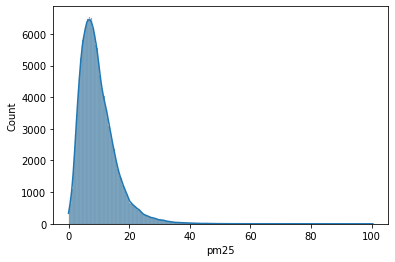

In [27]:
sns.histplot(data=df, x=df.pm25, kde=True)

In [28]:
df.isna().sum()

year_month        0
ZIP10             0
GEOID10           0
pm25              0
year_month_zip    0
dtype: int64

In [29]:
df.describe()

,pm25
count,400368.000000
mean,9.665053
std,5.941817
min,0.000000
25%,5.551852
50%,8.492593
75%,12.462500
max,100.378029


In [30]:
# check how many readings per zipcode

t = df.groupby('ZIP10')['year_month_zip'].count()

In [24]:
display(t)

ZIP10
89010    228
89019    228
89060    228
89061    228
89439    228
        ... 
96148    228
96150    228
96155    228
96161    228
97635    228
Name: year_month_zip, Length: 1756, dtype: int64

<AxesSubplot:>

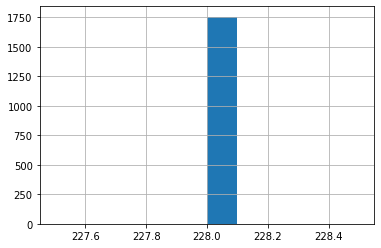

In [25]:
t.hist()